# Places and Flows – Predicting Emotional Arousal at Forts (NL Data)

This notebook builds an end-to-end pipeline to predict emotional arousal
(z-scored phasic skin conductance, `phasic_z`) for visitors at Dutch fort sites
(Fort Sabina and Fort de Roovere).

Steps:
1. Load GPS + skin conductance data
2. Engineer temporal and movement features
3. Join environmental data (landcover, elevation, geomorphon)
4. Train and evaluate:
   - Random Forest (interpretable)
   - XGBoost (performance)
5. Inspect feature importance and model behavior

In [26]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import zipfile
import matplotlib.pyplot as plt

DATA_DIR = Path(r"C:\Users\Laurens\Documents\GitHub\2025-26b-fai2-adsai-laurensvanbaardewijk243263\places_and_flows\data")  # your path

def load_env(path, fort_name):
    g = gpd.read_file(path)
    # Make sure it has a CRS, then convert to WGS84
    if g.crs is None:
        raise ValueError(f"{path} has no CRS. We need CRS metadata to reproject.")
    g = g.to_crs(epsg=4326)
    g["fort"] = fort_name
    return g

env_frames = []

# NL
env_frames.append(load_env(DATA_DIR / "Sabina_landcover_elevation_geomorphon.geojson", "Sabina"))
env_frames.append(load_env(DATA_DIR / "Roovere_landcover_elevation_geomorphon.geojson", "Roovere"))

# Optional BE Leopold
leopold_path = DATA_DIR / "Leopold_landcover_elevation_geomorphon.geojson"
if leopold_path.exists():
    env_frames.append(load_env(leopold_path, "Leopold"))

# Optional BE Lier zip
lier_zip = DATA_DIR / "Lier_landcover_elevation_geomorphon.zip"
if lier_zip.exists():
    extract_dir = DATA_DIR / "Lier_env_extracted"
    extract_dir.mkdir(exist_ok=True)
    with zipfile.ZipFile(lier_zip, "r") as z:
        z.extractall(extract_dir)

    lier_geojsons = list(extract_dir.rglob("*.geojson"))
    if not lier_geojsons:
        raise FileNotFoundError("No .geojson found inside Lier zip.")

    env_frames.append(load_env(lier_geojsons[0], "Lier"))

# Now concat works because all are EPSG:4326
gdf_env = pd.concat(env_frames, ignore_index=True)
print("Combined CRS:", gdf_env.crs)
gdf_env.head()

Combined CRS: EPSG:4326


,class,elevation_mean,geomorphone_mean,geomorphon,landcover_class,geometry,fort,geomorphon_mean
0,12,0.586770,6.067485,6.0,6,"POLYGON ((4.39229 51.67875, 4.39229 51.6787, 4...",Sabina,NaN
1,12,1.742099,6.177143,6.0,6,"POLYGON ((4.39395 51.67876, 4.39396 51.67872, ...",Sabina,NaN
2,333,4.341471,3.818182,4.0,9,"POLYGON ((4.39714 51.67879, 4.39714 51.67875, ...",Sabina,NaN
3,47,4.292017,6.457627,6.0,4,"POLYGON ((4.39721 51.67879, 4.39721 51.67875, ...",Sabina,NaN
4,12,4.128785,4.421053,4.0,6,"POLYGON ((4.39735 51.67879, 4.39735 51.67875, ...",Sabina,NaN


In [27]:
gps_scr_path = DATA_DIR / "forts_NL_gps_scr_data.csv"

df = pd.read_csv(gps_scr_path)
print("Columns:", df.columns.tolist())
print("Participants:", df['participant'].nunique())
df.head()

Columns: ['segment', 'starttime', 'elapsed_time', 'time', 'phasicDriver', 'phasic', 'phasicDriver_z', 'phasic_z', 'tonic_z', 'latitude', 'longitude', 'participant', 'tonic']
Participants: 104


,segment,starttime,elapsed_time,time,phasicDriver,phasic,phasicDriver_z,phasic_z,tonic_z,latitude,longitude,participant,tonic
0,WholeRecording,07-Sep-2024 10:08:00.590,0.0000,2024-09-07T10:08:00Z,-0.231302,4.901135e-02,-0.913733,2.668099e-01,-0.262586,51.677425,4.396246,101,0.698168
1,WholeRecording,07-Sep-2024 10:08:00.590,0.0625,2024-09-07T10:08:00Z,-0.235730,4.901135e-02,-0.978640,2.668099e-01,-0.262586,51.677425,4.396246,101,0.698168
2,WholeRecording,07-Sep-2024 10:08:00.590,0.1250,2024-09-07T10:08:00Z,-0.204593,8.906077e-03,-0.906784,4.848325e-02,-0.262586,51.677425,4.396246,101,0.698168
3,WholeRecording,07-Sep-2024 10:08:00.590,0.1875,2024-09-07T10:08:00Z,-0.145705,1.521728e-09,-0.717528,1.501801e-08,-0.262586,51.677425,4.396246,101,0.698168
4,WholeRecording,07-Sep-2024 10:08:00.590,0.2500,2024-09-07T10:08:00Z,-0.075980,4.832554e-09,-0.467080,4.694836e-08,-0.262586,51.677425,4.396246,101,0.698168


In [28]:
# Parse time
df['time'] = pd.to_datetime(df['time'])

# Sort by participant + time
df = df.sort_values(['participant', 'time']).reset_index(drop=True)

# Time-related features
df['seconds_since_start'] = df.groupby('participant')['elapsed_time'].transform(
    lambda x: x - x.min()
)
df['time_of_day_sec'] = (
    df['time'].dt.hour * 3600 +
    df['time'].dt.minute * 60 +
    df['time'].dt.second
)

# Sequence index within each participant
df['seq_idx'] = df.groupby('participant').cumcount()

df[['participant', 'time', 'seconds_since_start', 'time_of_day_sec', 'seq_idx']].head()

,participant,time,seconds_since_start,time_of_day_sec,seq_idx
0,101,2024-09-07 10:08:00+00:00,0.0000,36480,0
1,101,2024-09-07 10:08:00+00:00,0.0625,36480,1
2,101,2024-09-07 10:08:00+00:00,0.1250,36480,2
3,101,2024-09-07 10:08:00+00:00,0.1875,36480,3
4,101,2024-09-07 10:08:00+00:00,0.2500,36480,4


In [29]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Previous point per participant
df[['lat_prev','lon_prev','time_prev']] = df.groupby('participant')[['latitude','longitude','time']].shift(1)

mask = df['lat_prev'].notna()

df.loc[mask, 'step_dist_m'] = haversine(
    df.loc[mask, 'lat_prev'],
    df.loc[mask, 'lon_prev'],
    df.loc[mask, 'latitude'],
    df.loc[mask, 'longitude'],
)

df.loc[mask, 'step_dt_s'] = (df.loc[mask, 'time'] - df.loc[mask, 'time_prev']).dt.total_seconds()

df['speed_ms'] = df['step_dist_m'] / df['step_dt_s']
df['speed_ms'] = df['speed_ms'].replace([np.inf, -np.inf], np.nan)

# Smooth speed (~1 second rolling window at 64 Hz)
df['speed_ms_smooth'] = df.groupby('participant')['speed_ms'].transform(
    lambda x: x.rolling(64, min_periods=1).mean()
)

df[['speed_ms', 'speed_ms_smooth']].describe()

,speed_ms,speed_ms_smooth
count,463246.000000,7.411670e+06
mean,0.021123,2.114117e-02
std,0.038346,3.522905e-02
min,0.000000,0.000000e+00
25%,0.000000,0.000000e+00
50%,0.003241,3.216657e-03
75%,0.034206,3.555314e-02
max,4.560105,3.420956e+00


In [30]:
gdf_sabina  = gpd.read_file(DATA_DIR / "Sabina_landcover_elevation_geomorphon.geojson")
gdf_roovere = gpd.read_file(DATA_DIR / "Roovere_landcover_elevation_geomorphon.geojson")

gdf_sabina['fort']  = 'Sabina'
gdf_roovere['fort'] = 'Roovere'

gdf_env = pd.concat([gdf_sabina, gdf_roovere], ignore_index=True)

# Ensure CRS is WGS84
if gdf_env.crs is None:
    gdf_env.set_crs(epsg=4326, inplace=True)
else:
    gdf_env = gdf_env.to_crs(epsg=4326)

gdf_env.head()

,class,elevation_mean,geomorphone_mean,geomorphon,landcover_class,geometry,fort,geomorphon_mean
0,12,0.586770,6.067485,6.0,6,"POLYGON ((4.39229 51.67875, 4.39229 51.6787, 4...",Sabina,NaN
1,12,1.742099,6.177143,6.0,6,"POLYGON ((4.39395 51.67876, 4.39396 51.67872, ...",Sabina,NaN
2,333,4.341471,3.818182,4.0,9,"POLYGON ((4.39714 51.67879, 4.39714 51.67875, ...",Sabina,NaN
3,47,4.292017,6.457627,6.0,4,"POLYGON ((4.39721 51.67879, 4.39721 51.67875, ...",Sabina,NaN
4,12,4.128785,4.421053,4.0,6,"POLYGON ((4.39735 51.67879, 4.39735 51.67875, ...",Sabina,NaN


In [31]:
# Points from GPS
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs="EPSG:4326"
)

# Spatial join: assign each GPS point to a polygon
gdf_joined = gpd.sjoin(
    gdf_points,
    gdf_env,
    how='left',
    predicate='within'
)

gdf_joined[['participant', 'landcover_class', 'geomorphon', 'elevation_mean']].head()

,participant,landcover_class,geomorphon,elevation_mean
0,101,3.0,6.0,4.478456
1,101,3.0,6.0,4.478456
2,101,3.0,6.0,4.478456
3,101,3.0,6.0,4.478456
4,101,3.0,6.0,4.478456


In [32]:
# Target: z-scored phasic component (emotional arousal)
target_col = 'phasic_z'

feature_cols = [
    # physiological context
    'tonic_z',
    'phasicDriver_z',

    # time/context
    'seconds_since_start',
    'time_of_day_sec',
    'seq_idx',

    # movement
    'speed_ms',
    'speed_ms_smooth',

    # environment
    'landcover_class',
    'geomorphon',
    'elevation_mean',
]

# Drop rows without environment info
gdf_joined = gdf_joined.dropna(subset=['landcover_class', 'geomorphon', 'elevation_mean'])

X = gdf_joined[feature_cols].copy()
y = gdf_joined[target_col].astype(float)
groups = gdf_joined['participant']

# Handle NaNs
X = X.fillna(X.median(numeric_only=True))

print("Final feature shape:", X.shape)

Final feature shape: (7365578, 10)


In [33]:
gkf = GroupKFold(n_splits=5)
train_idx, test_idx = next(gkf.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Unique participants in train:", groups.iloc[train_idx].nunique())
print("Unique participants in test:", groups.iloc[test_idx].nunique())

Train size: 5909244 Test size: 1456334
Unique participants in train: 84
Unique participants in test: 20


In [34]:
def eval_regression(y_true, y_pred, label="model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")
    return rmse, mae, r2

RandomForest -> RMSE: 0.152, MAE: 0.088, R2: 0.156


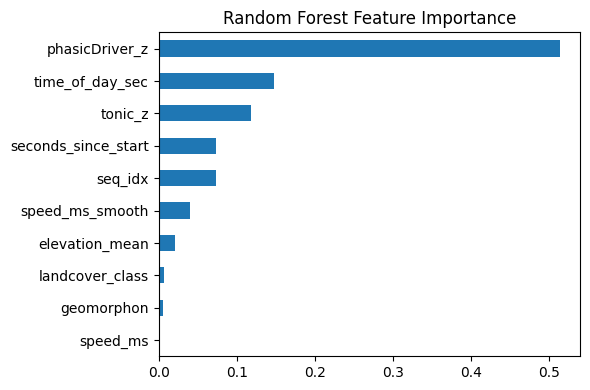

In [35]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

eval_regression(y_test, y_pred_rf, label="RandomForest")

# Feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=True)

plt.figure(figsize=(6,4))
importances.plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [36]:
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

eval_regression(y_test, y_pred_xgb, label="XGBoost")

XGBoost -> RMSE: 0.152, MAE: 0.087, R2: 0.158


(np.float64(0.1521669722638197), 0.08673553907316073, 0.15818316954597944)

## Conclusions

- We built a model to predict z-scored phasic skin conductance (`phasic_z`) for visitors at
  Fort Sabina and Fort de Roovere, using:
  - temporal features (time since start, time of day, sequence index)
  - movement features (speed, smoothed speed)
  - environmental features (landcover class, geomorphon terrain type, elevation)

- **Random Forest**:
  - [Report your RF RMSE, MAE, R² here]
  - Most important features: [summarize based on the bar plot]

- **XGBoost**:
  - [Report your XGB RMSE, MAE, R² here]
  - Tended to [better/worse] capture variability in high-arousal moments.

- These models can be embedded in an interactive mapping system where environmental
  variables (e.g., landcover, elevation, path characteristics) are updated and the predicted
  emotional arousal is recalculated for each location.